# EXPLORATORY DATA ANALYSIS

This notebook aims at providing an overview of the data that we have at hand. We have 3 datasets to work with:

* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* sell_prices.csv - Contains information about the price of the products sold per store and date.

These dataset involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI).

## SETUP LIBRARIES

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from datetime import datetime

%matplotlib inline
plt.rcParams['figure.dpi'] = 200

## CALENDAR

Load the calendar dataset.

In [28]:
calendar = pd.read_csv('data/calendar.csv')
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


Documentation gives us that:

*   date: The date in a “y-m-d” format.
*   wm_yr_wk: The id of the week the date belongs to.
*   weekday: The type of the day (Saturday, Sunday, …, Friday).
*   wday: The id of the weekday, starting from Saturday.
*   month: The month of the date.
*   year: The year of the date.
*   event_name_1: If the date includes an event, the name of this event.
*   event_type_1: If the date includes an event, the type of this event.
*   event_name_2: If the date includes a second event, the name of this event.
*   event_type_2: If the date includes a second event, the type of this event.
*   snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.

However, the *d* variable, which was not explained in the documentation, gives the order of days starting from 2011-01-29, which is d_1.


In [29]:
print('Starting: ' + str(calendar['date'].min()) + '; Ending:' + str(calendar['date'].max()))

Starting: 2011-01-29; Ending:2016-06-19


Our dates are defined between 2011-01-29 and 2016-06-19.

### Events
We have 4 event-related variables, two for the name and 2 for the type of it.

In [30]:
calendar[['event_name_1', 'event_type_1']].drop_duplicates()

,event_name_1,event_type_1
0,NaN,NaN
8,SuperBowl,Sporting
16,ValentinesDay,Cultural
23,PresidentsDay,National
39,LentStart,Religious
46,LentWeek2,Religious
47,StPatricksDay,Cultural
50,Purim End,Religious
85,OrthodoxEaster,Religious
87,Pesach End,Religious


In [31]:
calendar[['event_name_2', 'event_type_2']].drop_duplicates()

,event_name_2,event_type_2
0,NaN,NaN
85,Easter,Cultural
827,Cinco De Mayo,Cultural
1177,OrthodoxEaster,Religious
1233,Father's day,Cultural


Those events can influence sales, probably with a lag - people buy their groceries and party supplies days before the event - hopefully!

### SNAP

Since this is a gubernmental program, a few items should be influenced by this feature. Let's see how it behaves along time.

In [32]:
snap_calendar = calendar[['date', 'snap_CA', 'snap_TX', 'snap_WI']].melt(id_vars='date', value_vars=['snap_CA', 'snap_TX', 'snap_WI'], var_name='snap', value_name='value').groupby('snap').sum()
snap_calendar.head()

,value
snap,
snap_CA,650
snap_TX,650
snap_WI,650


We have 650 days (out of 1913) where snap buying was allowed.

## PRICES

The next step is to understand the Prices dataset. Its information is essential in predicting future sales since that price usually influences what and how much of something we'll buy.

In [33]:
prices = pd.read_csv('data/sell_prices.csv')

prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [34]:
prices.shape

(6841121, 4)

From the docs:

* store_id: The id of the store where the product is sold. 
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

Basically, we have 1 price per product, per store, and per week - HOWEVER it is only available if it was sold in that store and in that week.

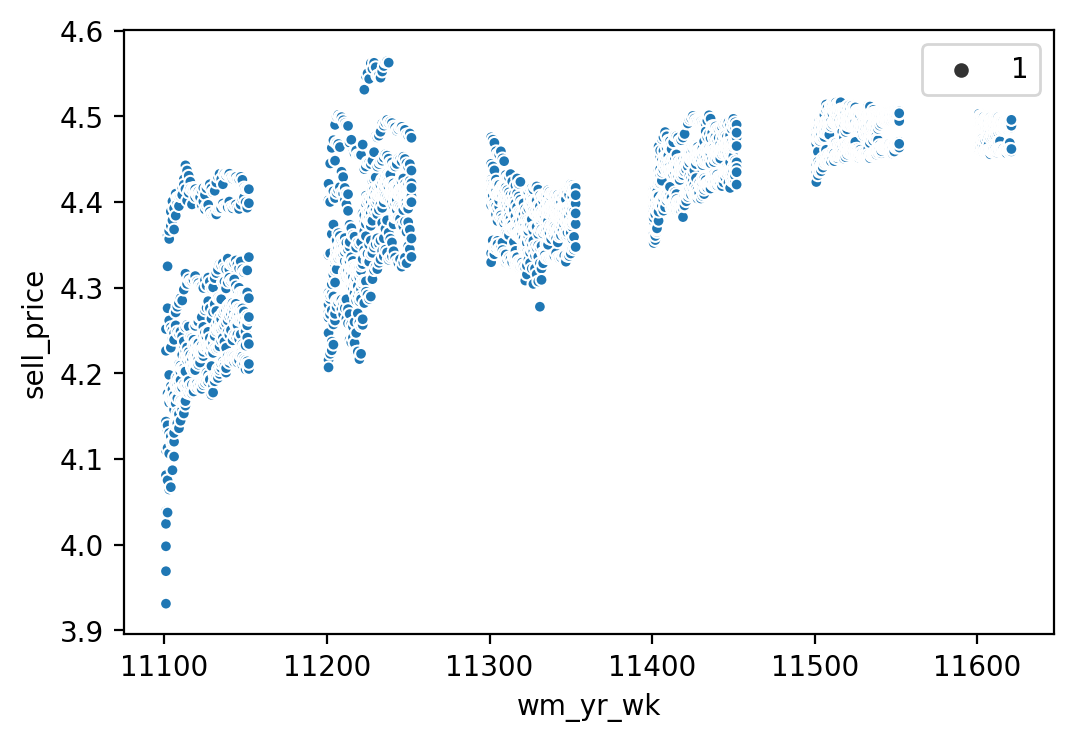

In [35]:
prices_wk = prices.groupby(['wm_yr_wk', 'store_id']).mean().reset_index()
sns.scatterplot(x='wm_yr_wk', y='sell_price', data=prices_wk, size=1)

It appears that we have weeks missing from the data, which could hinder our predicting efforts.

## SALES

The documentation says that the Sales dataset has the following variables:

* item_id: The id of the product.
* dept_id: The id of the department the product belongs to.
* cat_id: The id of the category the product belongs to.
* store_id: The id of the store where the product is sold.
* state_id: The State where the store is located.
* d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 

The first aspect that appears to be relevant here is the dataset format: it is in a wide format, with dates being represented by columns. To understand the impact this could have we can look at the relationship between the tables. While the **prices** and **calendar** dataset can be joined by the *wm_yr_wk* variable, the **sales** dataset can be joined with **prices** by the *item_id * and *store_id* variables. However, the **calendar** dataset can only be joined to the **sales** dataset through its *d* variable, which is represented by the columns d_1 through d_1913. This indicates that we need to transform our dataset in to a long format, where these columns become the *d* variable and we can then join the other datasets. 

Let's worry about this latter. First, to understand the dataset.

In [36]:
sales = pd.read_csv('data/saleS_train_validation.csv')
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


A few questions to answer to gain confidence with the data:

* which product has sold the most/least units?
* which department has sold the most/least units?
* which store has sold the most/least units?
* What is the relationship between stores and departments?
* which state sold the most/least units?

The first step to answer those questions is to sum all sales in time, for each row.

In [42]:
sales['total'] = sales.iloc[:,6:].sum(axis=1)
sales_sum = sales[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'total']]

**Which product has sold the most units?**

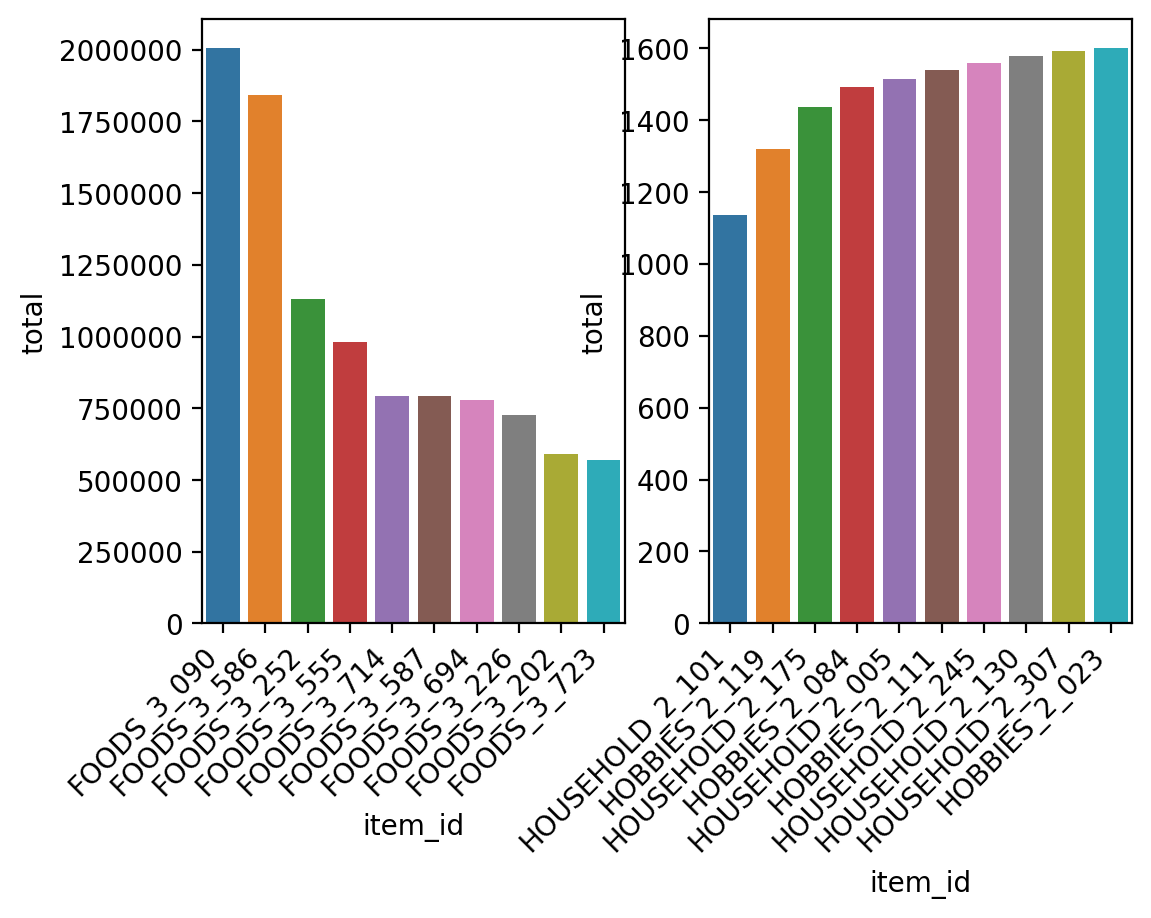

In [71]:
most_sold_products = sales_sum[['item_id', 'total']].groupby('item_id').sum().nlargest(10, 'total').reset_index()
least_sold_products = sales_sum[['item_id', 'total']].groupby('item_id').sum().nsmallest(10, 'total').reset_index()

fig, ax = plt.subplots(1,2)
chart_1 = sns.barplot(x='item_id', y='total', data=most_sold_products, ax=ax[0])
chart_1.set_xticklabels(chart_1.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_2 = sns.barplot(x='item_id', y='total', data=least_sold_products, ax=ax[1])
chart_2.set_xticklabels(chart_2.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.show()

From the chart above, the item *FOODS_3_090* sold over 2 million units in the years covered, while the 3rd position is given to *FOODS_3_252*. Although it sold just shy of 1.25 million units, the feat is recognizable. On the other side of the chart, the least sold items are those in the Household and Hobbies sections, with less than 1600 units sold over the dataset time span. 

Now, for the second question:

**which department has sold the most/least units?** 


[Text(0, 0, 'FOODS_3'),
 Text(0, 0, 'HOUSEHOLD_1'),
 Text(0, 0, 'FOODS_2'),
 Text(0, 0, 'HOBBIES_1'),
 Text(0, 0, 'FOODS_1'),
 Text(0, 0, 'HOUSEHOLD_2'),
 Text(0, 0, 'HOBBIES_2')]

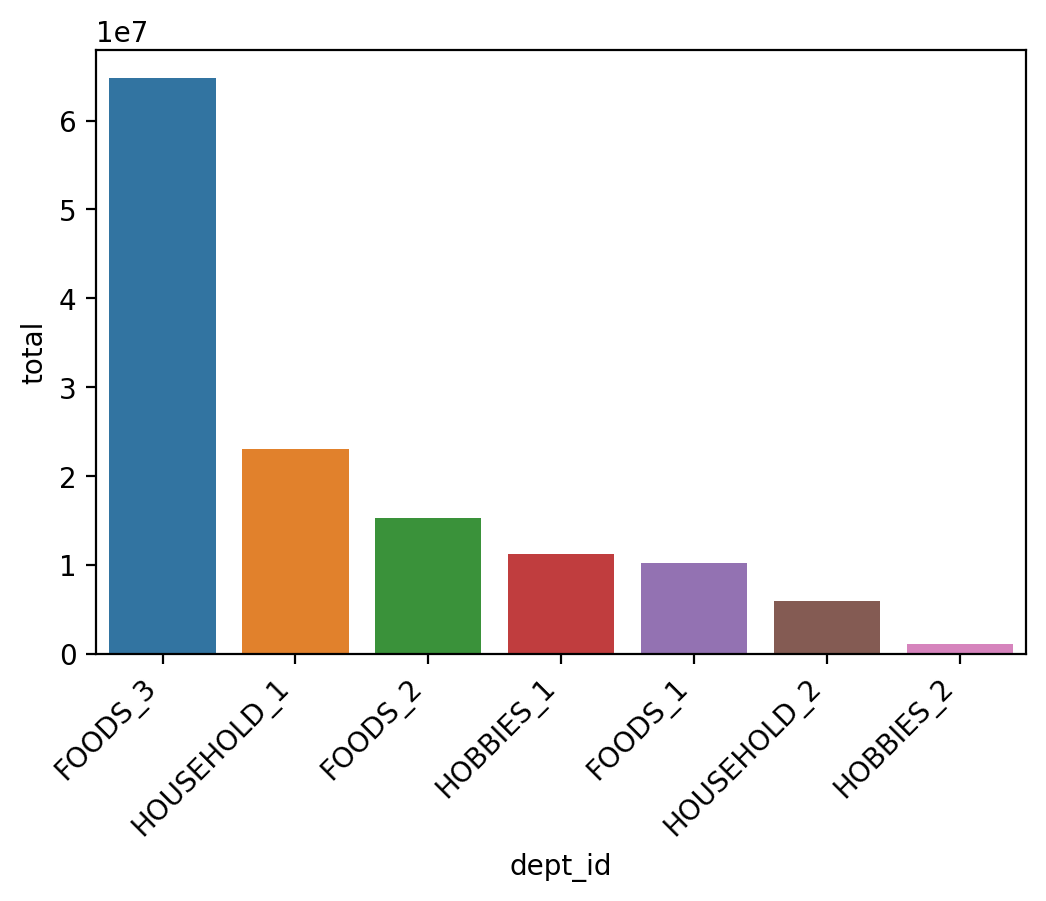

In [81]:
sales_by_department = sales_sum[['dept_id', 'total']].groupby('dept_id').sum().sort_values('total', ascending=False).reset_index()
chart = sns.barplot(x='dept_id', y='total', data=sales_by_department)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

As expected, the *FOODS_3* department has sold the most units over the years (more than 6 million units), while *HOBBIES_2* and *HOUSEHOLD_2* have sold the least.

Our 3rd question:

**which store has sold the most/least units?**

[Text(0, 0, 'CA_3'),
 Text(0, 0, 'CA_1'),
 Text(0, 0, 'TX_2'),
 Text(0, 0, 'WI_2'),
 Text(0, 0, 'WI_3'),
 Text(0, 0, 'TX_3'),
 Text(0, 0, 'CA_2'),
 Text(0, 0, 'TX_1'),
 Text(0, 0, 'WI_1'),
 Text(0, 0, 'CA_4')]

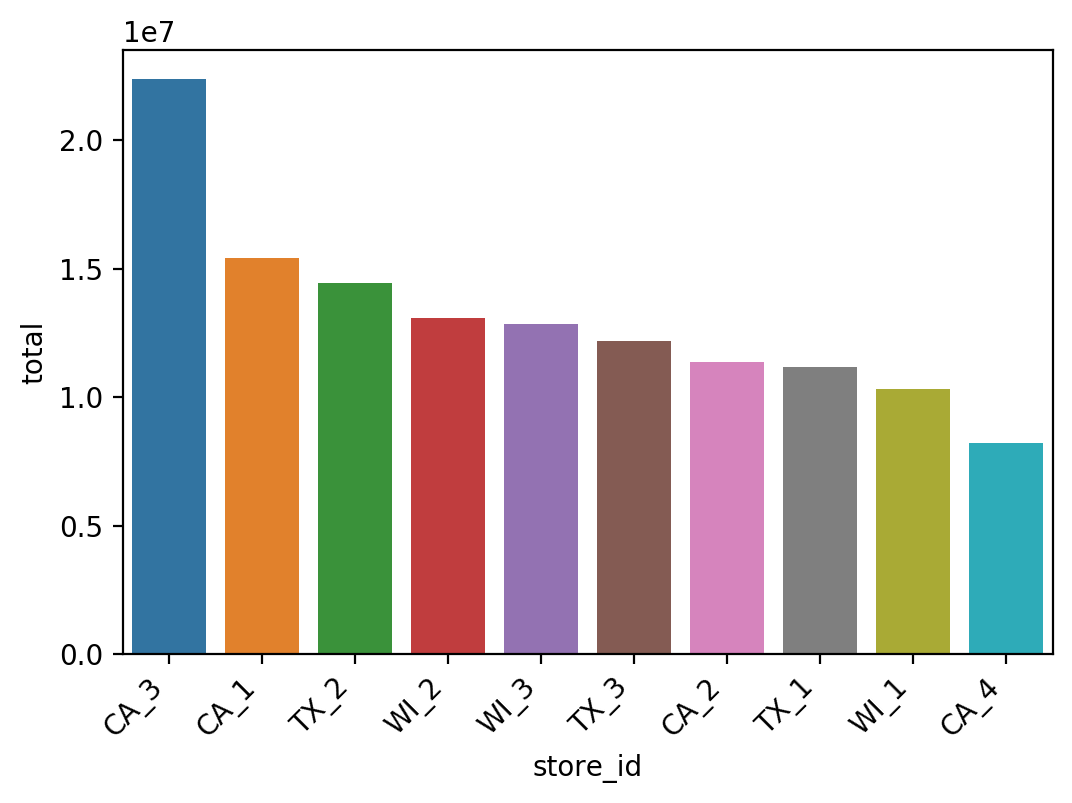

In [82]:
sales_by_store = sales_sum[['store_id', 'total']].groupby('store_id').sum().sort_values('total', ascending=False).reset_index()
chart = sns.barplot(x='store_id', y='total', data=sales_by_store)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

The top store is the *CA_3*, located in California, with over 2 million units sold. It is followed by store *CA_1*, which amassed 1.5 million units sold, and *TX_2*, with almost 1.5 million units too. The least performing stores are *CA_4* and *WI_1*.

4th question: 

**What is the relationship between stores and departments?**

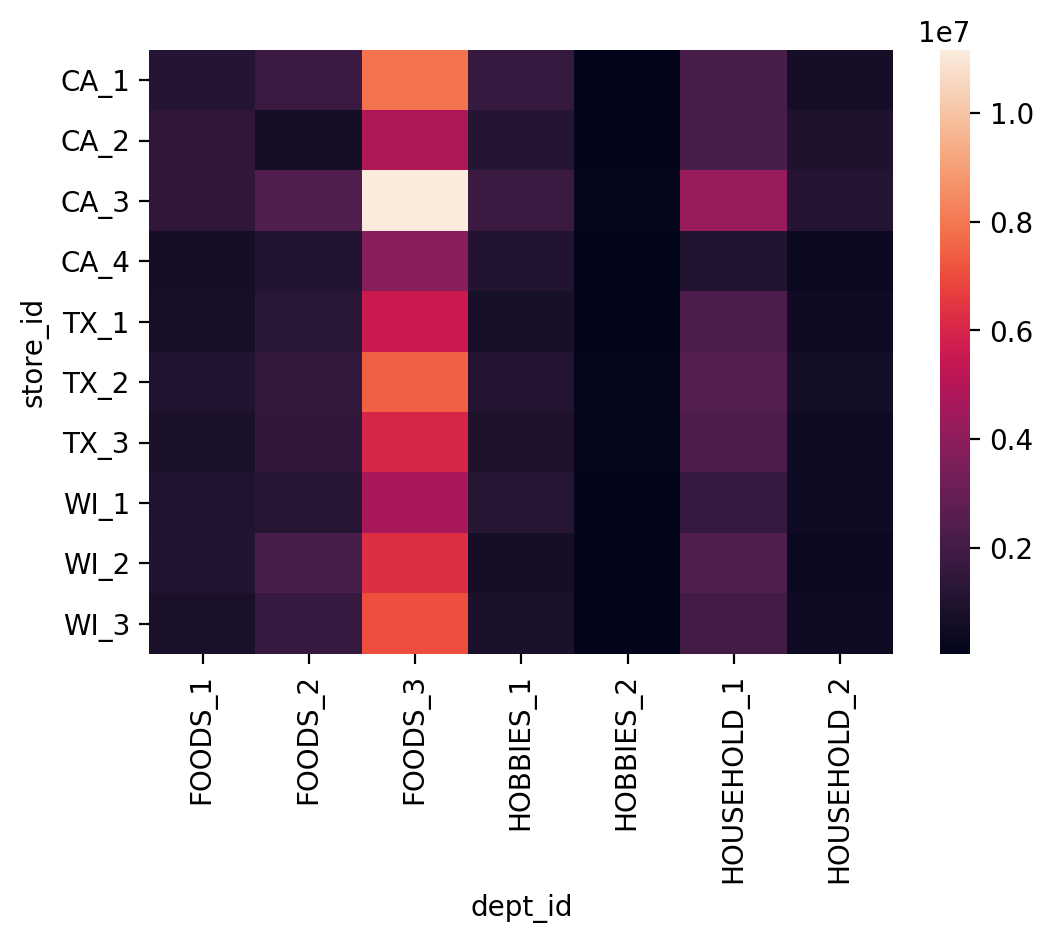

In [91]:
sales_by_store_dept = sales_sum[['store_id', 'dept_id', 'total']].groupby(['store_id', 'dept_id']).sum().reset_index().pivot('store_id', 'dept_id', 'total')
sns.heatmap(sales_by_store_dept)

*CA_3* store also performs well when selling products from the *HOUSEHOLD_1* department. No other relationship is clearly visible in the chart above.

We can procceed with our 5th qustion:

**which state sold the most/least units?**


[Text(0, 0, 'CA'), Text(0, 0, 'TX'), Text(0, 0, 'WI')]

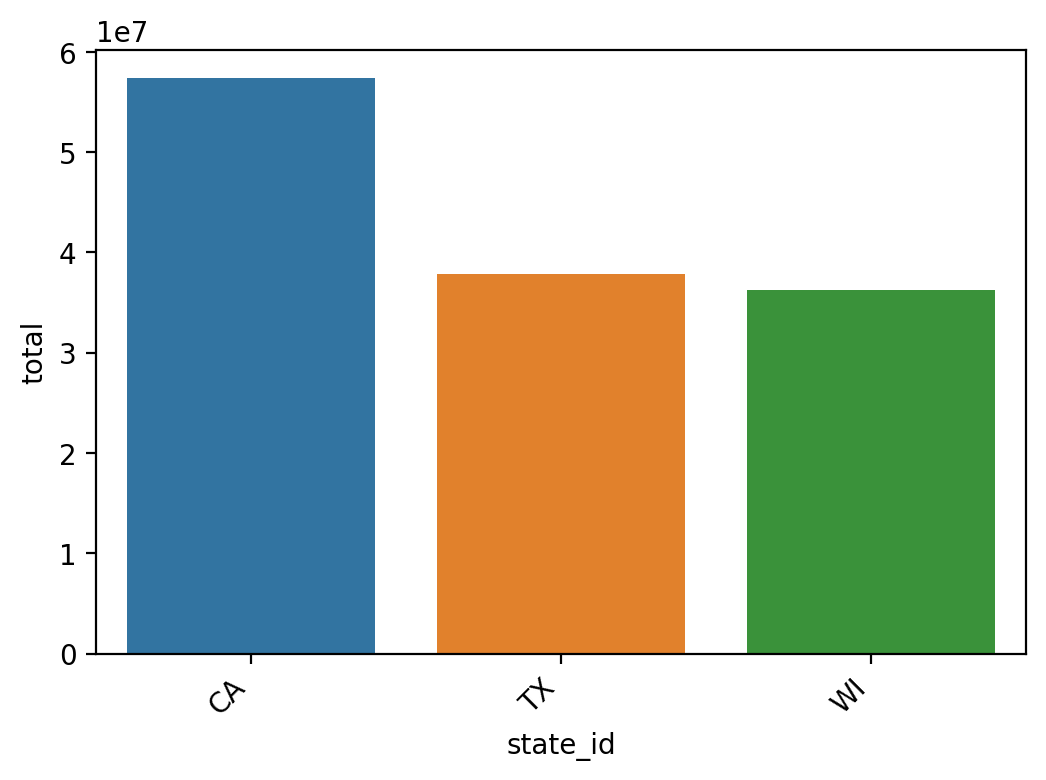

In [92]:
sales_by_state = sales_sum[['state_id', 'total']].groupby('state_id').sum().sort_values('total', ascending=False).reset_index()
chart = sns.barplot(x='state_id', y='total', data=sales_by_state)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

California is the state where Walmart has sold the most units. This is normal, given that California has 4 stores and both Texas, Wioming only have 3 each - thus presenting similar results. To make it a more fair comparison, we can check the average units sold per store by state:

[Text(0, 0, 'CA'), Text(0, 0, 'TX'), Text(0, 0, 'WI')]

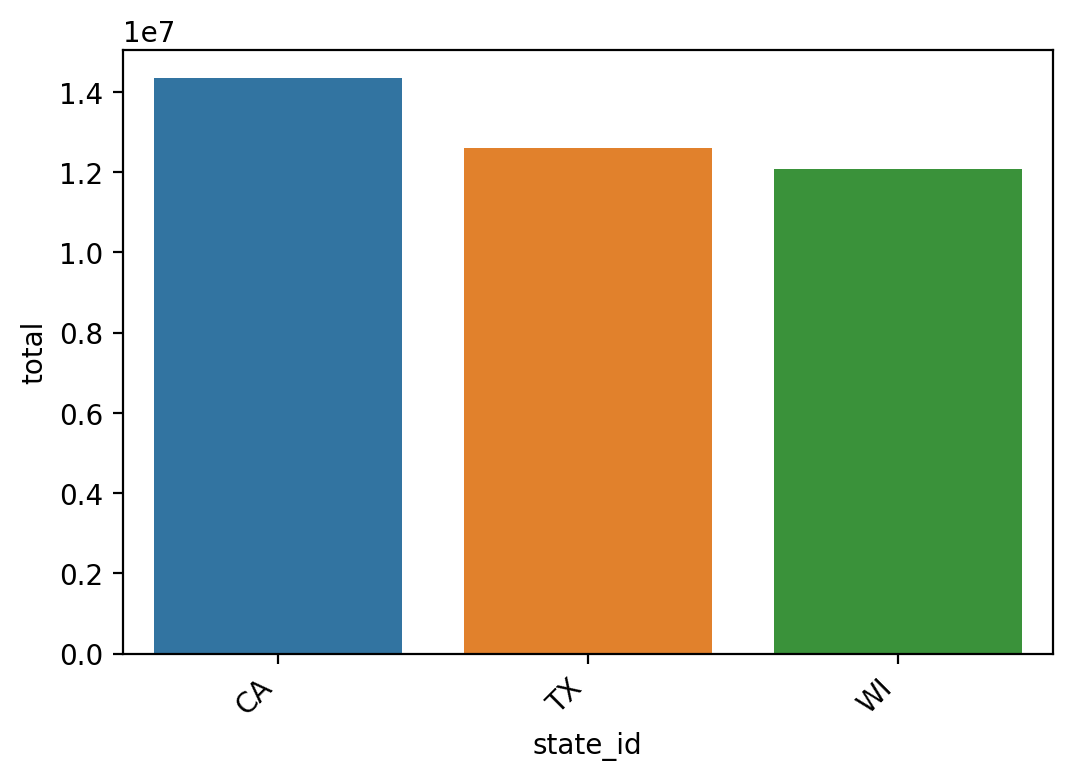

In [93]:
sales_by_state_avg = sales_sum[['state_id', 'store_id', 'total']].groupby(['state_id', 'store_id']).sum().reset_index()
sales_by_state_avg = sales_by_state_avg.groupby('state_id').mean().sort_values('total', ascending=False).reset_index()
chart = sns.barplot(x='state_id', y='total', data=sales_by_state_avg)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


In this comparison, however, California still takes the first place, although at a much lower difference.

## NEXT STEPS

Our next step is to build the dataset that will be used in the prediction exercise. This step will require some thinking on how to overcome the dataset size issue - 58 million rows are not feasible to be handled by our simple PCs.

A few assumptions for the next step:

* Sales are independent on State - we can have a model for each one;
* Stores are far away enough from one another that their sales are also independent - a person won't go to *CA_3* if a product is not available at *CA_2*. Hence, we can also model each store separatedly; and
* Products can be dependent on each other, and we cannot model each one separatedly.